<h1><center>cs1001.py , Tel Aviv University, Spring 2018</center></h1>
<img src="http://www.pngall.com/wp-content/uploads/2016/05/Python-Logo-PNG-Image-180x180.png" width=50/>

## Recitation 11

We solved a question about iterators + generators and the Karp-Rabin algorithm for string matching. Then we discussed digital image processing and denoising methods.

#### Code for printing several outputs in one cell (not part of the recitation):

In [153]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Question 2  in <a href="http://tau-cs1001-py.wdfiles.com/local--files/home-assignments-2017b/HW6_2017b.pdf"> this exercise</a>

In [ ]:
def fingerprint(string, basis=2**16, r=2**32-3):
    """ used to computes karp-rabin fingerprint of the pattern
    employs Horner method (modulo r) """
    partial_sum=0
    for x in string:
        partial_sum=(partial_sum*basis+ord(x)) % r
    return partial_sum

def slide(prev_fp,prev_char,next_char,b_power,basis=2**16,r=2**32-3):
    new_fp=((prev_fp-ord(prev_char)*b_power)*basis+ord(next_char)) % r
    return new_fp

### Section (a)

In [ ]:
def kr_gen(text,length,basis=2**16,r=2**32-3):
    fp = fingerprint(text[:length])
    yield fp
    b_power = pow(basis,length-1,r)
    for s in range(1,len(text)-length+1):
        fp = slide(fp,text[s-1],text[s-1+length],b_power)
        yield fp

In [154]:
gen = kr_gen("abracadabra", 3)
next(gen)
next(gen)


6422933

7471495

In [155]:
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)
next(gen)

6357433

6488452

6357389

6553988

6357390

6422933

7471495

StopIteration: 

### Section (b)

In [157]:
def generate_shared_substrings(text1,text2,length):
    g1 = kr_gen(text1, length)
    i1 = 0
    for fp1 in g1:
        g2 = kr_gen(text2, length)
        i2 = 0
        for fp2 in g2:
            if fp1 == fp2:
                yield(i1, i2)
            i2 += 1
        i1 += 1

In [158]:
g = generate_shared_substrings("abcdef","xcdefx",3)
next(g)
next(g)

(2, 1)

(3, 2)

In [159]:
next(g)

StopIteration: 

## Digital image processing

### class Matrix from matrix.py

In [160]:
############################################################################
###    class Matrix
###    This is our own Matrix class with an additional display() method for image visualization
###    Also, functions 'save' and 'load' enable working with .bitmap files
###    Note that __repr__ avoids printing very large matrices (would stuck IDLE)
############################################################################



class Matrix:
    """
    Represents a rectangular matrix with n rows and m columns.
    """

    def __init__(self, n, m, val=0):
        """
        Create an n-by-m matrix of val's.
        Inner representation: list of lists (rows)
        """
        assert n > 0 and m > 0
        #self.rows = [[val]*m]*n #why this is bad?
        self.rows = [[val]*m for i in range(n)]

    def dim(self):
        return len(self.rows), len(self.rows[0])

    def __repr__(self):
        if len(self.rows)>10 or len(self.rows[0])>10:
            return "Matrix too large, specify submatrix"
        return "<Matrix {}>".format(self.rows)

    def __eq__(self, other):
        return isinstance(other, Matrix) and self.rows == other.rows

    def copy(self):
        ''' brand new copy of matrix '''
        n,m = self.dim()
        new = Matrix(n,m)
        for i in range (n):
           for j in range (m):
               new[i,j] = self[i,j]
        return new

    # cell/sub-matrix access/assignment
    ####################################
    def __getitem__(self, ij): #ij is a tuple (i,j). Allows m[i,j] instead m[i][j]
        i,j = ij
        if isinstance(i, int) and isinstance(j, int):
            return self.rows[i][j]
        elif isinstance(i, slice) and isinstance(j, slice):
            M = Matrix(1,1) # to be overwritten
            M.rows = [row[j] for row in self.rows[i]]
            return M
        else:
            return NotImplemented

    def __setitem__(self, ij, val): #ij is a tuple (i,j). Allows m[i,j] instead m[i][j]
        i,j = ij
        if isinstance(i,int) and isinstance(j,int):
            assert isinstance(val, (int, float, complex))
            self.rows[i][j] = val
        elif isinstance(i,slice) and isinstance(j,slice):
            assert isinstance(val, Matrix)
            n,m = val.dim()
            s_rows = self.rows[i]
            assert len(s_rows) == n and len(s_rows[0][j]) == m
            for s_row, v_row in zip(s_rows,val.rows):
                s_row[j] = v_row
        else:
            return NotImplemented

    # arithmetic operations
    ########################
    def entrywise_op(self, other, op):
        if not isinstance(other, Matrix):
            return NotImplemented
        assert self.dim() == other.dim()
        n,m = self.dim()
        M = Matrix(n,m)
        for i in range(n):
            for j in range(m):
                M[i,j] = op(self[i,j], other[i,j])
        return M

    def __add__(self, other):
        return self.entrywise_op(other,lambda x,y:x+y)


    def __sub__(self, other):
        return self.entrywise_op(other,lambda x,y:x-y)
    
    def __neg__(self):
        n,m = self.dim()
        return Matrix(n,m) - self


    def __mul__(self, other):
        if isinstance(other, Matrix):
            return self.multiply_by_matrix(other)
        elif isinstance(other, (int, float, complex)):
            return self.multiply_by_scalar(other)
        else:
            return NotImplemented

    __rmul__ = __mul__
        
    def multiply_by_scalar(self, val):
        n,m = self.dim()
        return self.entrywise_op(Matrix(n,m,val), lambda x,y :x*y)
###a more efficient version, memory-wise. 
##        n,m = self.dim()
##        M = Matrix(n,m)
##        for i in range(n):
##            for j in range(m):
##                M[i,j] = self[i,j] * val
##        return M

    def multiply_by_matrix(self, other):
        assert isinstance(other, Matrix)
        n,m = self.dim()
        n2,m2 = other.dim()
        assert m == n2
        M = Matrix(n,m2)
        for i in range(n):
            for j in range(m2):
                M[i,j] = sum(self[i,k] * other[k,j] for k in range(m))
        return M


    # Input/output
    ###############
    def save(self, filename):
        f = open(filename, 'w')
        n,m = self.dim()
        print(n,m, file=f)
        for row in self.rows:
            for e in row:
                print(e, end=" ", file=f)
            print("",file=f) #newline
        f.close()

    @staticmethod
    def load(filename):
        f = open(filename)
        line = f.readline()
        n,m = [int(x) for x in line.split()]
        result = Matrix(n,m)
        for i in range(n):
            line = f.readline()
            row = [int(x) for x in line.split()]
            assert len(row) == m
            result.rows[i] = row
        return result

    # display - for image visualization - no need to understand this
    ################################################################
    def display(self, title=None, zoom=None):
        height, width = self.dim()
        pixels = " ".join('{' + ' '.join('#'+'{:02x}'.format(int(pixel))*3
                                       for pixel in row) + '}'
                          for row in self.rows)

        def tk_worker(root):
            pi = tkinter.PhotoImage(width=width,height=height)
            pi.put(pixels)
            if zoom is not None:
                assert zoom > 0
                if zoom > 1:
                    pi = pi.zoom(zoom)
                elif zoom < 1:
                    pi = pi.subsample(zoom)
            tl = tkinter.Toplevel(master=root)
            tl.title('Matrix' if title is None else title)
            lb = tkinter.Label(master=tl, image=pi)
            lb.pi = pi
            lb.pack()
            return tl

        if TKTHREAD_ENABLED:
            with _TkThread.the_lock:
                _TkThread.the_queue.append(tk_worker)
        else:
            root = tkinter.Tk()
            root.withdraw()
            tl = tk_worker(root)
            tl.protocol("WM_DELETE_WINDOW", root.destroy)
            root.mainloop()

################# More code for image visualization
# Enabled only for linux/windows machines.
import sys
import tkinter
import time

TKTHREAD_ENABLED = sys.platform in ('win32', 'linux')

if TKTHREAD_ENABLED:
    import threading

    class _TkThread(threading.Thread):
        the_lock = threading.RLock()
        the_queue = []
        
        def __init__(self, *args, **kwargs):
            threading.Thread.__init__(self, *args, **kwargs)
            self.setDaemon(True)

        def run(self):
            root = tkinter.Tk()
            root.withdraw()
            while True:
                with self.the_lock:
                    func = self.the_queue.pop() if self.the_queue else None
                if func is not None:
                    func(root)
                root.update()
                time.sleep(.1)
    _TkThread().start()




Additional code for showing PIL images and Matrix in IPython Notebook (needed for this recitation).
<b>You do not need to understand this code!</b>

In [161]:
# This allows to show PIL images and Matrix in IPython Notebook
from io import BytesIO
from IPython.core import display
from PIL import Image

def display_pil_image(im):
    """Displayhook function for PIL Images, rendered as PNG."""
    b=BytesIO()
    img.save(b,format='png')
    data = b.getvalue()
    display.display_png(data, raw=True)

def display_matrix_image(mat):
    img = Image.new('L',size=(mat.dim()[1],mat.dim()[0]))
    for i in range(mat.dim()[0]):
        for j in range(mat.dim()[1]):
            img.putpixel((j,i),mat[i,j])
    b=BytesIO()
    img.save(b,format='png')
    data = b.getvalue()
    display.display_png(data, raw=True)

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Matrix, display_matrix_image)


Content of format_conversion.py

In [ ]:
from PIL import Image

def image2bitmap(path):
    ''' Given a string 'path' of image file in "real" format (.jpg/.bmp etc.)
        creates a new file in format .bitmap under the same directory
        which can then be loaded into class Matrix using Matrix.load() ''' 
    image = Image.open(path)
    image = image.convert("L")          # converts to 8 bit grayscale image
    im = image.load()                   # stores image in an array
    w,h = image.size                    # image dimensions

    new_file_name = (path.split(".")[-2]).split("/")[-1] + ".bitmap"
    new_file = open(new_file_name, 'w')

    print(h,w, file=new_file)
    for i in range(h):
        for j in range(w):
            print(int(im[j,i]), end=" ", file = new_file)
        print("", file=new_file)#newline

    new_file.close()


def bitmap2image(path):
    ''' Given a string path of image file in .bitmap format
        creates a .bmp file under the same directory '''
    mat = Matrix.load(path)
    n,m = mat.dim()
    image = Image.new('L', (m,n))
    im = image.load()
    for i in range(n):
       for j in range(m):
           im[j,i] = mat[i,j]
    image.save((path.split(".")[-2]).split("/")[-1]  + ".bmp")


Format conversion example:

In [ ]:
#creates a bitmap file from the given *.jpg file
image2bitmap("simpsons.JPG")


In [ ]:

#creates a bmp file from the given *.bitmap file
bitmap2image("simpsons.bitmap")

### images.py

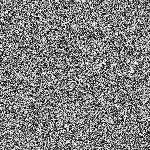

Matrix too large, specify submatrix

In [162]:
import random 

#######################
## Simple random image
#######################
n = 150
m = 150
mat = Matrix(n,m)
for i in range(n):
    for j in range(m):
        mat[i,j] = random.randint(0,255)
mat

In [163]:

#######################
## Useful operation
#######################

def join_h(mat1, mat2):
    """ joins two matrices, side by side with some separation """
    n1,m1 = mat1.dim()
    n2,m2 = mat2.dim()
    m = m1+m2+10
    n = max(n1,n2)
    new = Matrix(n, m, val=255)  # fill new matrix with white pixels

    new[:n1,:m1] = mat1
    new[:n2,m1+10:m] = mat2

    return new


def join_v(mat1, mat2):
    """ joins two matrices, vertically with some separation """
    n1,m1 = mat1.dim()
    n2,m2 = mat2.dim()
    n = n1+n2+10
    m = max(m1,m2)
    new = Matrix(n, m, val=255)  # fill new matrix with white pixels

    new[:n1,:m1] = mat1
    new[n1+10:n,:m2] = mat2

    return new

def join(*mats, direction):
    ''' *mats enables a variable number of parameters.
        direction is either 'h' or 'v', for horizontal or vertical join, respectively '''
    func = join_v if direction == 'v' else join_h
    res = mats[0] #first matrix parameter
    for mat in mats[1:]:
        res = func(res, mat)
    return res



In [164]:
im = Matrix.load("./simpsons.bitmap")
print(im.dim())


(438, 782)


### Can you guess what's in this cropped image?

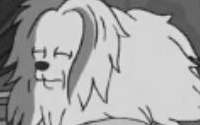

Matrix too large, specify submatrix

In [165]:
im[25:150,250:450]



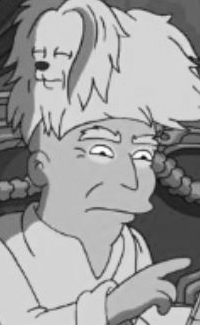

Matrix too large, specify submatrix

In [166]:
im[25:350,250:450]

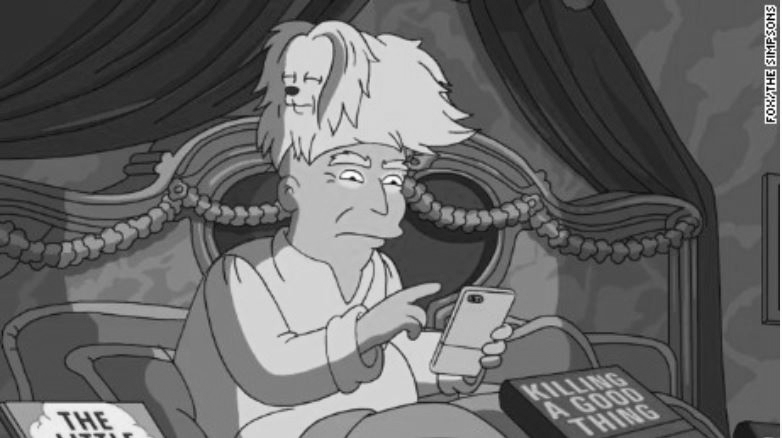

Matrix too large, specify submatrix

In [167]:
im

### image manipulation

In [168]:
def what(im):
    n,m = im.dim()
    im2 = Matrix(n,m)
    for i in range(n):
        im2.rows[i] = sorted(im.rows[i])
    return im2



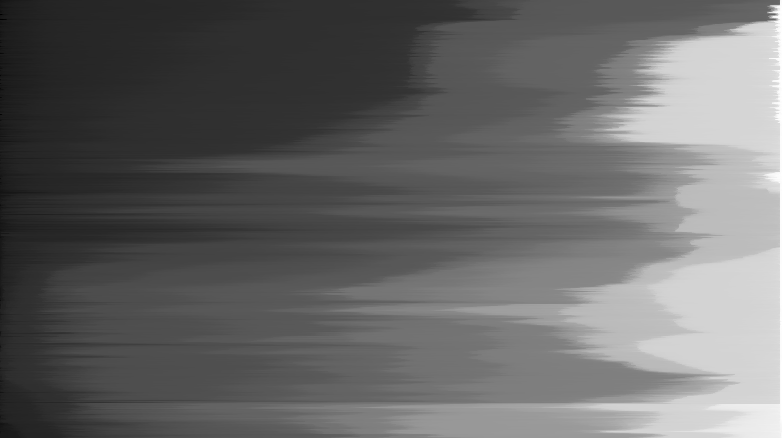

Matrix too large, specify submatrix

In [169]:
what(im)

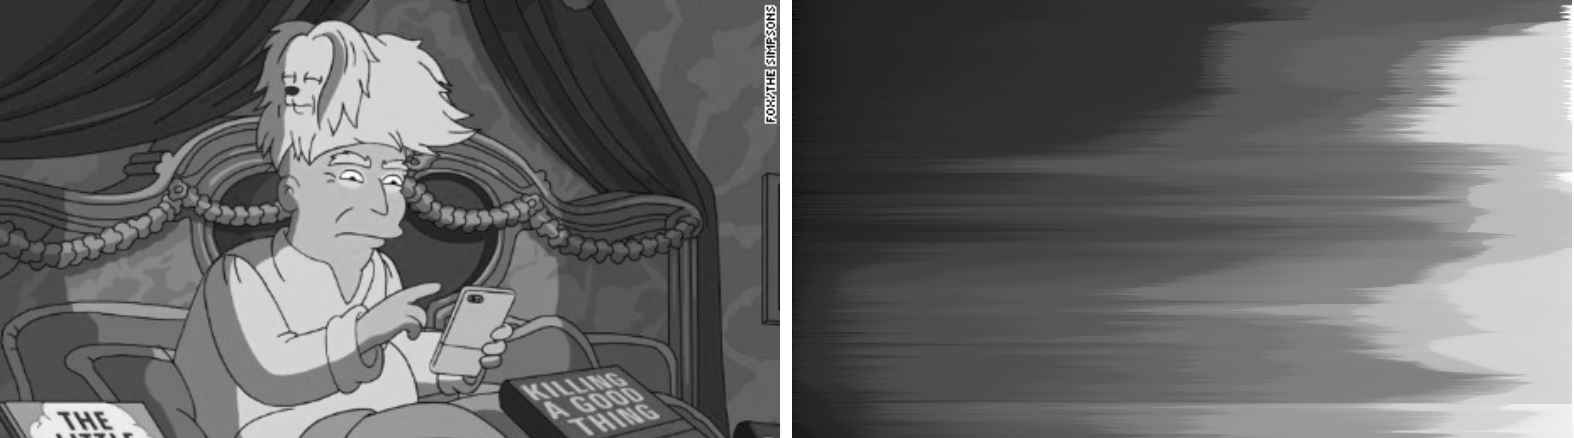

Matrix too large, specify submatrix

In [170]:
join(im, what(im), direction="h")


Generating the negative of a given image

In [171]:
def negate(im):
    n,m = im.dim()
    im2 = Matrix(n,m)
    for i in range(n):
        for j in range(m):
            im2[i,j] = 255 - im[i,j]
    return im2


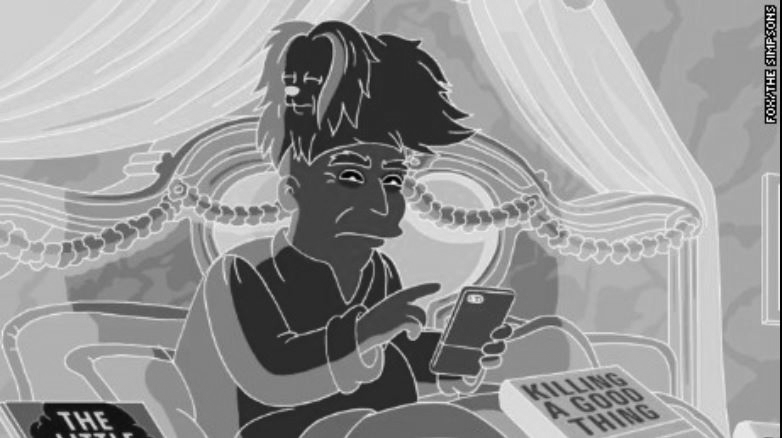

Matrix too large, specify submatrix

In [172]:
negate(im)

## Noise reduction

### Content of noise.py

In [179]:
import random

##################################
## Adding noise to images,
## for testing noise reduction
##################################

def add_gauss(mat, sigma=10):
    ''' Generates Gaussian noise with mean 0 and SD sigma.
        Adds indep. noise to pixel,
        keeping values in 0..255'''
    n,m = mat.dim()
    new = mat.copy()
    for i in range(n):
        for j in range(m):
            noise = round(random.gauss(0,sigma))
            if noise > 0:
                new[i,j] = min(mat[i,j] + noise, 255)
            elif noise < 0:
                new[i,j] = max(mat[i,j] + noise, 0)

    return new


def add_SP(mat, p=0.01):
    ''' Generates salt and pepper noise:
        Each pixel is "hit" indep. with prob. p
        If hit, it has fifty fifty chance of becoming
        white or black. '''
    n,m = mat.dim()
    new = mat.copy()
    for i in range(n):
        for j in range (m):
            rand = random.random() #a random float in [0,1)
            if rand < p:
                if rand < p/2:
                    new[i,j] = 0
                else:
                    new[i,j] = 255
    return new



##################################
## Local denoising methods
##################################

def items(mat):
    ''' flatten mat elements into a list '''
    n,m = mat.dim()
    lst = [mat[i,j] for i in range(n) for j in range(m)]
    return lst


def local_operator(mat, op, k=1):
    ''' Apply op to every pixel.
        op is a local operator on a square neighbourhood
        of size 2k+1 X 2k+1 around a pixel '''
    n,m = mat.dim()
    res = mat.copy()  # brand new copy of A
    for i in range(k,n-k):
        for j in range(k,m-k):
            res[i,j] = op(items(mat[i-k:i+k+1,j-k:j+k+1]))
    return res


def average(lst):
    n = len(lst)
    return round(sum(lst)/n)

def median(lst):
    sort_lst = sorted(lst)
    n = len(sort_lst)
    if n%2==1:    # odd number of elements. well defined median
        return sort_lst[n//2]
    else:         # even number of elements. average of middle two
        return (int(sort_lst[-1+n//2]) + int(sort_lst[n//2])) // 2



def local_means(mat, k=1):
    return local_operator(mat, average, k)

def local_medians(mat, k=1):
    return local_operator(mat, median, k)



Now, guess what's in the following cropped image

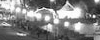

Matrix too large, specify submatrix

In [173]:
im = Matrix.load("guess.bitmap")
im[500:540,250:350]

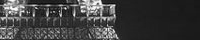

Matrix too large, specify submatrix

In [174]:
im[400:440,150:350]

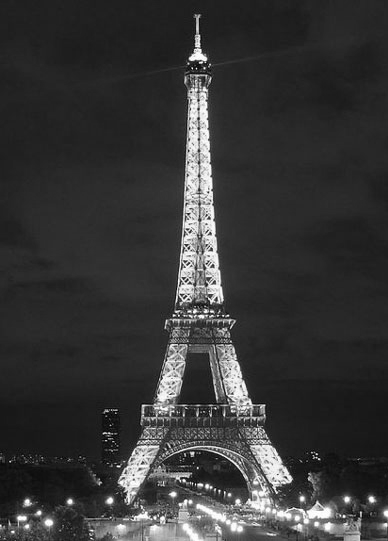

Matrix too large, specify submatrix

In [175]:
im

Adding Gaussian noise

Adding Gaussian noise with sigma=10


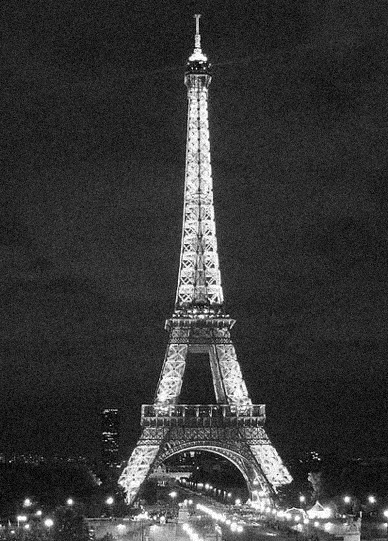

Matrix too large, specify submatrix

Adding Gaussian noise with sigma=50


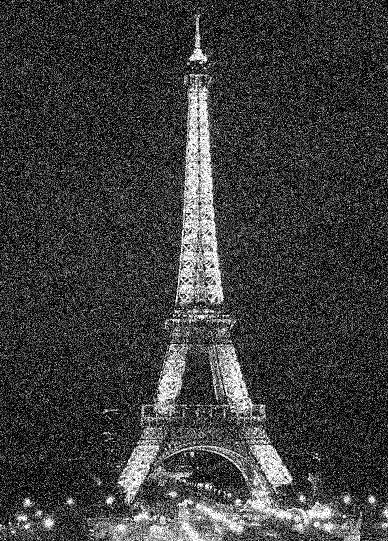

Matrix too large, specify submatrix

In [177]:
print("Adding Gaussian noise with sigma=10")
add_gauss(im)
print("Adding Gaussian noise with sigma=50")
add_gauss(im, 50)

Adding SP noise

SP noise with p=0.01


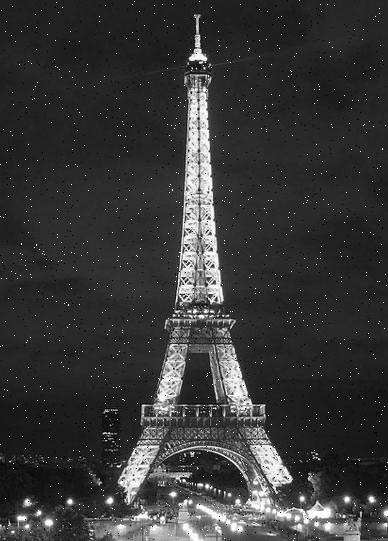

Matrix too large, specify submatrix

SP noise with p=0.3


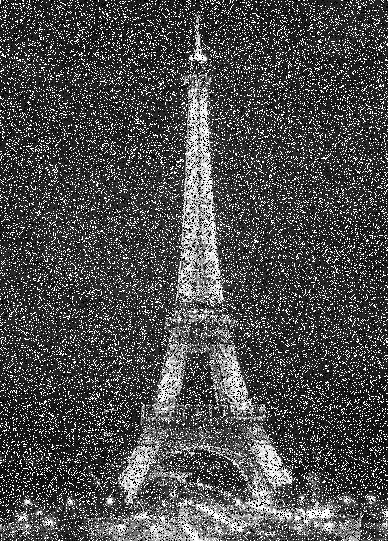

Matrix too large, specify submatrix

In [178]:
print("SP noise with p=0.01")
add_SP(im)
print("SP noise with p=0.3")
add_SP(im, p=0.3)


The basic scheme for denoising is that we change the value of each pixel simultaneously with respect to the values of its neighbours using some function (e.g., local means or local medians). The neighborhood  of a pixel is the group of pixels in a square around it.

<table style="width:100%" dir="ltr">
  <tr>
            <th>method</th>
            <th>pros</th> 
            <th>cons</th>
          <th>works well with</th>
  </tr>
  <tr>
            <td>local means</td>
            <td>fast, works well on smooth areas</td> 
            <td>blurs edges, affected by outliers</td>
              <td>Gaussian noise</td>
  </tr>
  <tr>
        <td>local medians</td>
        <td>preserves edges, not affected by outliers</td> 
        <td>median calculation is slow, eliminates fine details (contours)</td>
      <td> SP noise</td>
  </tr>
</table>

	 

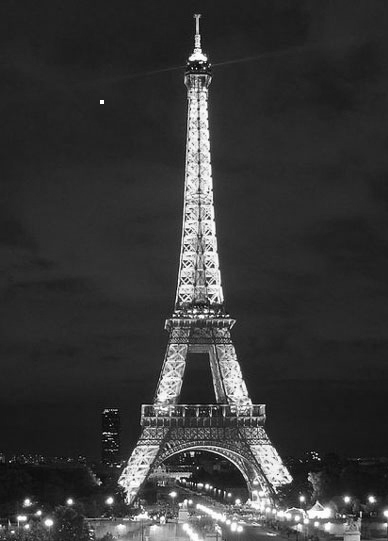

Matrix too large, specify submatrix

In [180]:
im = Matrix.load("guess.bitmap")
for i in range(4):
    for j in range(4):
        im[100+i,100+j] = 255
im


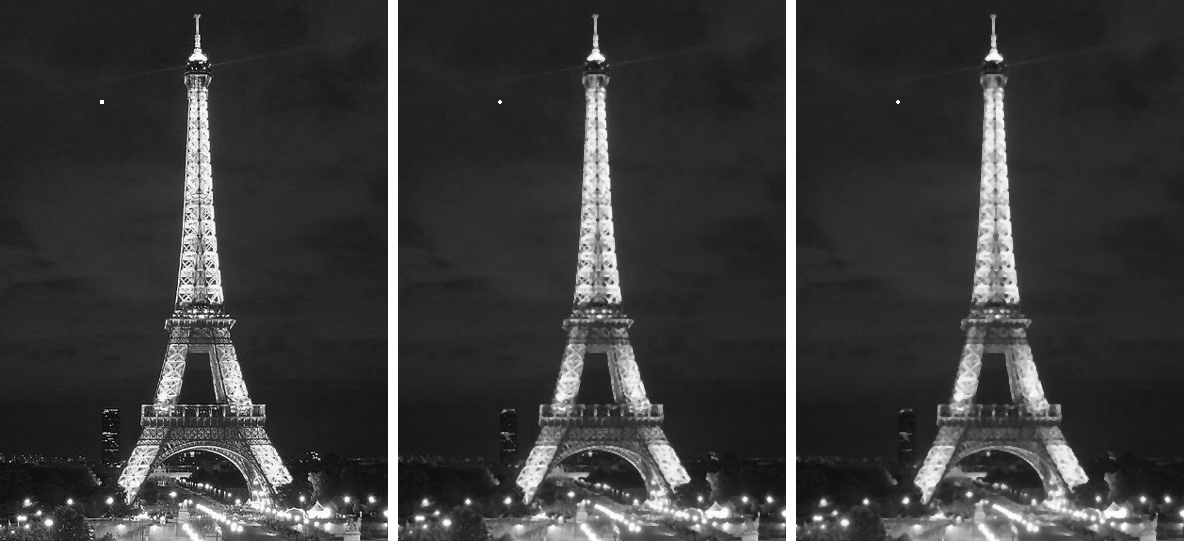

Matrix too large, specify submatrix

In [181]:
im1 = local_medians(im, k=1)
im1_2 = local_medians(im1, k=1)
join(im, im1, im1_2, direction="h")


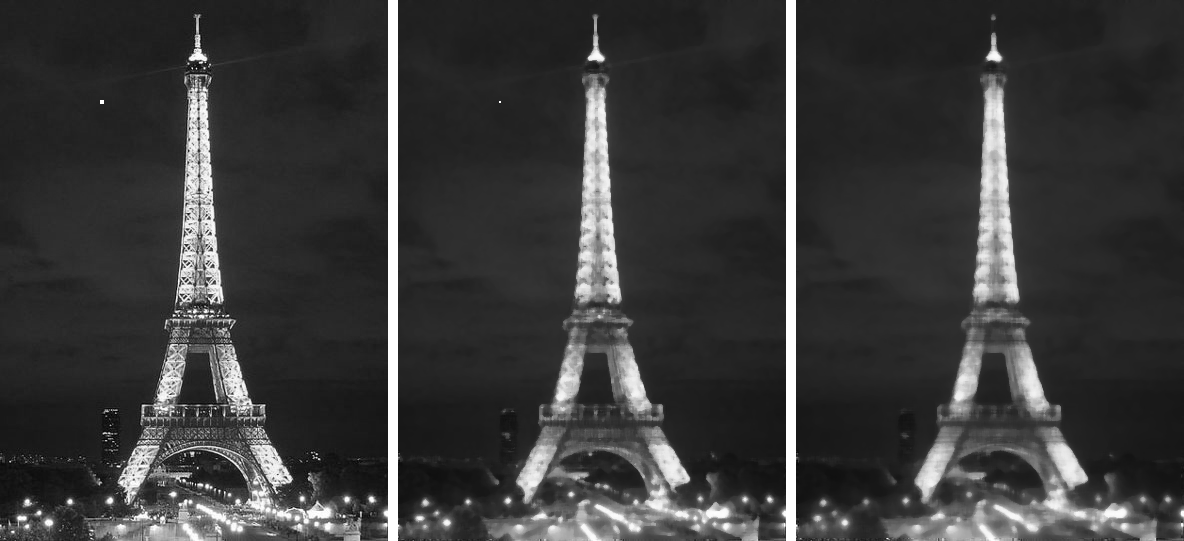

Matrix too large, specify submatrix

In [182]:
im2 = local_medians(im, k=2)
im3 = local_medians(im, k=3)
join(im, im2, im3, direction="h")

#### Solution: bounded local medians

When darkness/brightness is extreme (close to 0 or 255) we can do better:

- fix only extreme values
- neighborhoods only include non-extreme values

In [ ]:

def bounded_median(lst):
    cell = lst[len(lst)//2] # cell needs correcting
    non_extreme = []
    if cell > 250: # fix white
        non_extreme = [val for val in lst if val <= 250]
    if cell < 5: # fix black
        non_extreme = [val for val in lst if val >= 5]
    if non_extreme != []:
        return median(non_extreme)
    return cell #all neighbors extreme

def bounded_local_medians(A, k=1):
    return local_operator(A, bounded_median, k)



In [183]:
im = Matrix.load("simpsons.bitmap")
im_noise = add_SP(im, p=0.65)

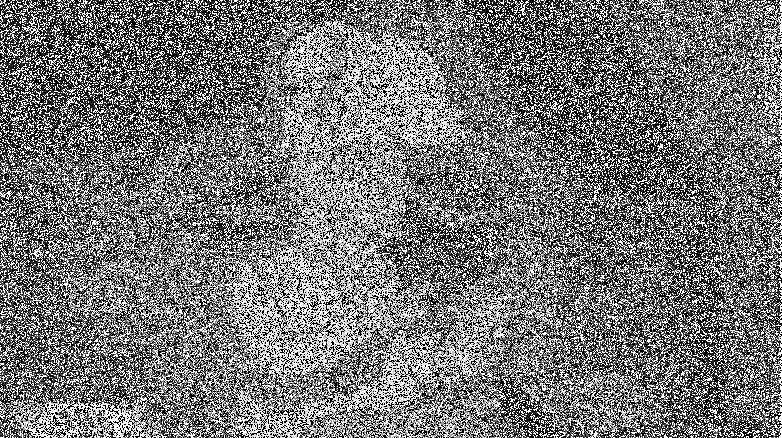

Matrix too large, specify submatrix

In [184]:
im_noise

In [185]:
local_medians_res = local_medians(im_noise)


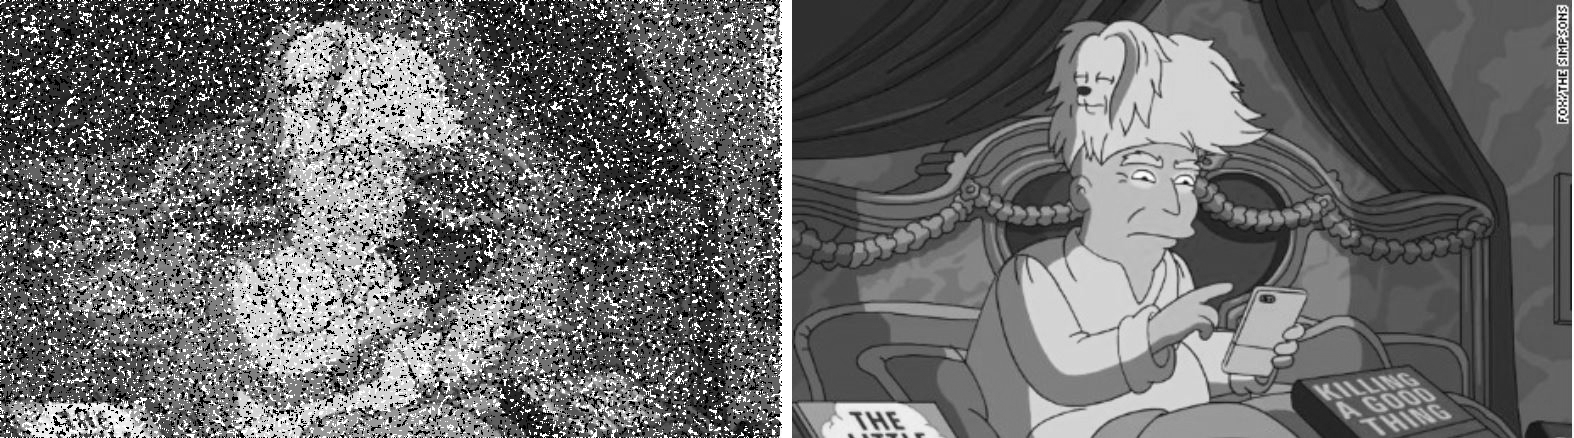

Matrix too large, specify submatrix

In [186]:
join(local_medians_res, im, direction="h")

In [187]:
im_denoised1 = bounded_local_medians(im_noise)


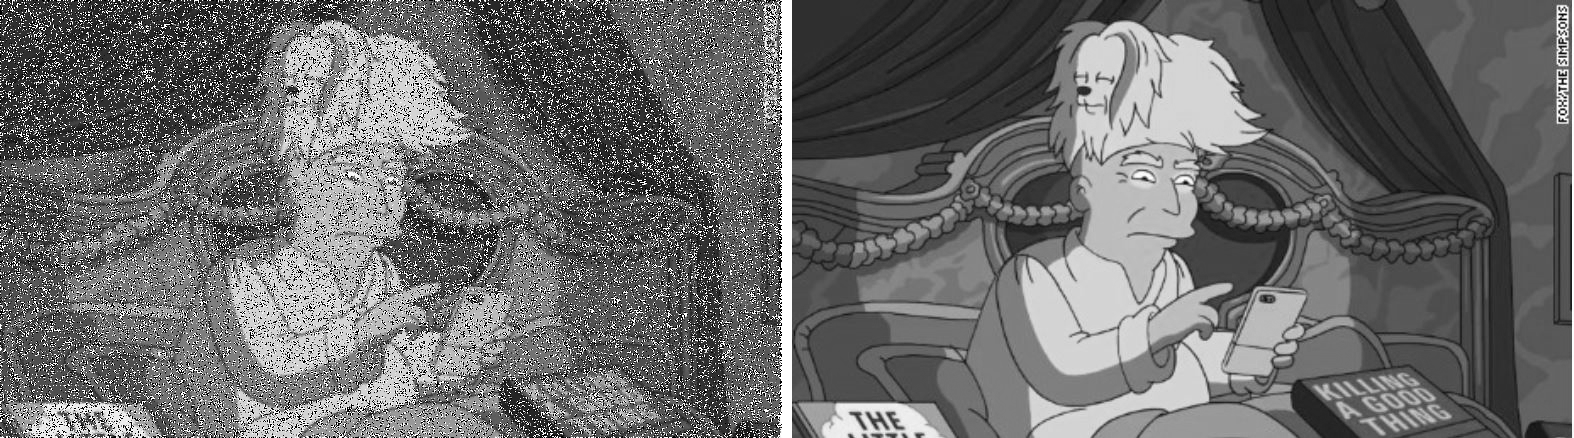

Matrix too large, specify submatrix

In [188]:
join(im_denoised1, im, direction="h")

In [189]:
im_denoised2 = bounded_local_medians(im_denoised1)


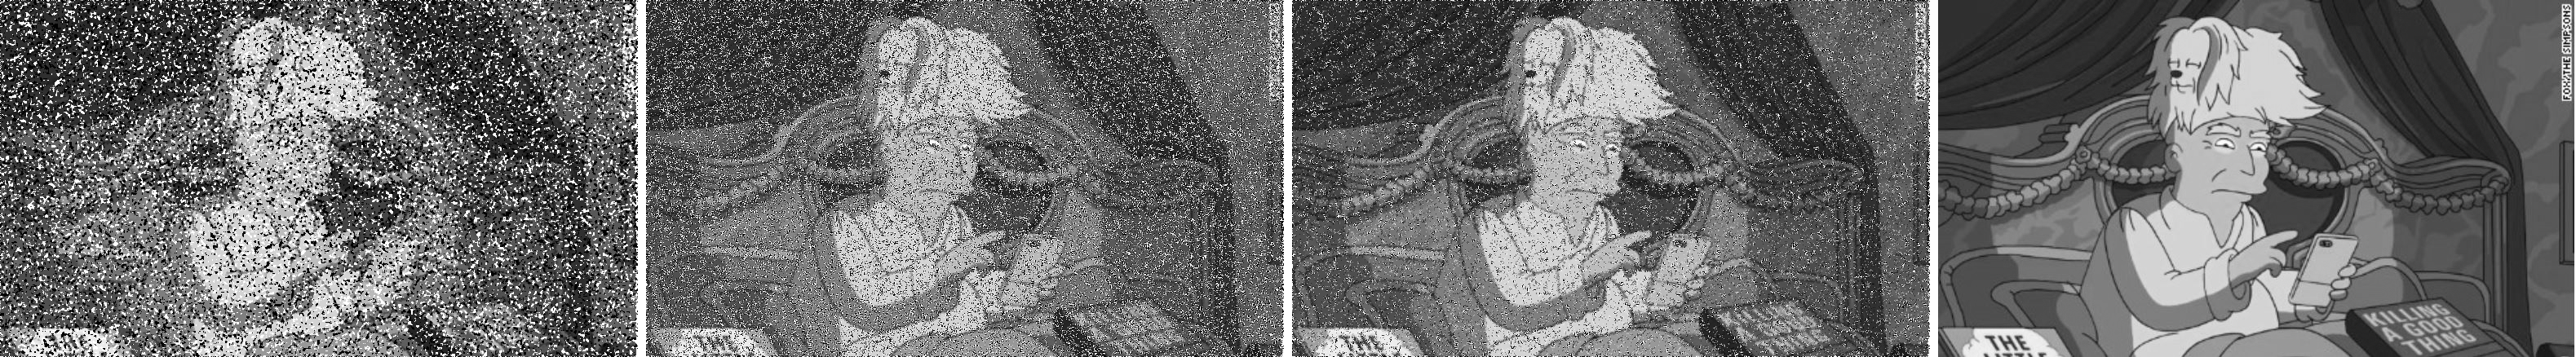

Matrix too large, specify submatrix

In [190]:
join(local_medians_res, im_denoised1, im_denoised2, im, direction="h")